testing the following for different paramter for delta t, U, the Hamiltonian etc. always gave the correct results

In [1]:
import tqdm

In [2]:
%load_ext autoreload
%autoreload 1
%aimport library
from library import *

# time evolution operator

In [3]:
from qiskit.quantum_info.operators import Operator
from scipy.linalg import expm
from copy import deepcopy

def create_time_evolution_gate_from_hamiltonian(H, dt):
    """
    H is given in units of hbar/s
    dt in s

    #TODO make it more performant by accepting H in form of a combination of Pauli matrices
    currently it converts them to numpy array calculates e^(i*H*dt) and creates an operator from that.
    """
    if isinstance(H, SparsePauliOp):
        H = H.to_matrix()
    N_qubits = np.log2(H.shape[0])
    assert N_qubits % 1 == 0, "shape of H is not of form 2^n."
    N_qubits = int(N_qubits)
    # factor 2 because this W will act both for W_odd and W_even.
    time_evolution_op = Operator(expm(-1j*H*dt*2))
    
    qc = QuantumCircuit(N_qubits, name='W')
    qc.unitary(time_evolution_op, range(N_qubits))
    return qc.to_instruction()
    

In [4]:
T=1
V=1

# |0> entspricht nicht vorhanden.
c0 = np.kron(np.eye(2), np.array([[0,0,],[1,0]]))
c1 = np.kron(np.array([[0,0,],[1,0]]), np.eye(2))
n0 = c0.T.conj() @ c0
n1 = c1.T.conj() @ c1
print(c0)
print(c1)
print(n0)
print(n1)
H = T * (c1.T.conj() @ c0 + c1 @ c0.T.conj()) + V * n1 @ n0
print(H)
W = create_time_evolution_gate_from_hamiltonian(H, .0)
print(get_matrix_for_gate(W, {}).to_matrix())

[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]]
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


In [5]:
from qiskit.circuit.library import TwoLocal

In [6]:
U = TwoLocal(3, ['rz', 'rx'], 'cx', 'linear', reps=1, parameter_prefix="u", name="U")
V = TwoLocal(4, ['rz', 'rx'], 'cx', 'linear', reps=1, parameter_prefix="v", name="V")
print(U)

     ┌───────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                                  ├
     │                                                                   │
q_1: ┤1 U(u[0],u[1],u[2],u[3],u[4],u[5],u[6],u[7],u[8],u[9],u[10],u[11]) ├
     │                                                                   │
q_2: ┤2                                                                  ├
     └───────────────────────────────────────────────────────────────────┘


In [7]:
U_param_values = np.random.random(12)
mps = iMPS(V, U, U_param_values)
braMPS = iMPS(V, U, U_param_values)

In [8]:
mps.U_params

{ParameterVectorElement(u[0]): 0.025819315156342615,
 ParameterVectorElement(u[1]): 0.12399090993073225,
 ParameterVectorElement(u[2]): 0.7757470429742435,
 ParameterVectorElement(u[3]): 0.3204192836193175,
 ParameterVectorElement(u[4]): 0.417756437919661,
 ParameterVectorElement(u[5]): 0.05915956864925409,
 ParameterVectorElement(u[6]): 0.534040148223098,
 ParameterVectorElement(u[7]): 0.6515438798174281,
 ParameterVectorElement(u[8]): 0.7048127216363702,
 ParameterVectorElement(u[9]): 0.34625476682120493,
 ParameterVectorElement(u[10]): 0.7530288795148308,
 ParameterVectorElement(u[11]): 0.9434935216580478}

In [9]:
get_transfer_matrix(mps, braMPS, W, plot_network=False)

array([[ 1.93057604e-01-7.43935649e-16j, -1.01300066e-03+3.92255002e-02j,
         1.18149843e-03-2.56960807e-01j, -8.37191936e-02-1.26366683e-02j,
        -1.01300066e-03-3.92255002e-02j,  4.29538008e-01-1.32059309e-15j,
         8.42598481e-02+8.29860051e-03j, -6.19251644e-02+2.49390309e-01j,
         1.18149843e-03+2.56960807e-01j,  8.42598481e-02-8.29860051e-03j,
         4.29538008e-01-1.81201866e-15j,  1.01300066e-03-3.92255002e-02j,
        -8.37191936e-02+1.26366683e-02j, -6.19251644e-02-2.49390309e-01j,
         1.01300066e-03+3.92255002e-02j,  1.93057604e-01-6.48786580e-16j],
       [-1.46096577e-03-1.34100530e-01j,  1.42712761e-02-6.83559473e-03j,
        -1.04395193e-01+7.75821241e-03j, -1.12828704e-02+3.44246149e-02j,
        -1.38994289e-02+7.56310471e-03j, -4.48639847e-02-2.19017480e-01j,
         9.49098052e-03-3.49611007e-02j,  1.04759081e-01+7.03783017e-02j,
         1.18828690e-01+4.25125033e-02j,  2.48827114e-03-3.61409156e-02j,
        -4.48639847e-02-2.19017480e-0

In [10]:
E = _
E.shape

(16, 16)

In [11]:
# check if identity is actually an eigenvalue here. This should be the case because our mps is automatically left-normalized due to unitarity of U.
np.round((np.eye(2**mps.bond_dim).flatten() @ E).reshape((2**mps.bond_dim,)*2),10)

array([[ 1.-0.j, -0.+0.j,  0.+0.j,  0.-0.j],
       [ 0.-0.j,  1.-0.j,  0.-0.j,  0.-0.j],
       [-0.+0.j,  0.-0.j,  1.-0.j, -0.-0.j],
       [ 0.-0.j, -0.+0.j,  0.-0.j,  1.-0.j]])

## test get_tranfer_matrix for more complicated example by comparing with result from quantum circuit

In [12]:
# third hamiltonian: transverse field Ising model
def hamiltonian_tfi_model(factor_ZZ, factor_X):
    """
    returns the H_odd for the transverse field Ising model.
    """
    #Z = np.array([[1,0],[0,-1]])
    #X = np.array([[0,1],[1,0]])
    Id = SparsePauliOp("I")
    Z = SparsePauliOp("Z")
    X = SparsePauliOp("X")
    # the X summand gets split up into two parts one for each lattice site to preserve translation invarianz
    #H = factor_ZZ * np.kron(Z, Z) + factor_X/2 * np.kron(X, np.eye(2)) + factor_X/2 * np.kron(np.eye(2), X)
    H = (factor_ZZ * Z ^ Z) + factor_X/2 * ( (X ^ Id) + (Id ^ X) )
    
    return H
    

H_params_after_Quench = {"factor_ZZ": 1, "factor_X": .2}
delta_t = .01
W = create_time_evolution_gate_from_hamiltonian(hamiltonian_tfi_model(**H_params_after_Quench), delta_t)

In [13]:
U = TwoLocal(2, ['rz', 'rx'], 'cx', 'linear', reps=1, parameter_prefix="u", name="U")
V = TwoLocal(2, ['rz', 'rx'], 'cx', 'linear', reps=1, parameter_prefix="v", name="V")
print(U)

     ┌─────────────────────────────────────────────┐
q_0: ┤0                                            ├
     │  U(u[0],u[1],u[2],u[3],u[4],u[5],u[6],u[7]) │
q_1: ┤1                                            ├
     └─────────────────────────────────────────────┘


In [14]:
U_param_values = np.random.random(8)
mps = iMPS(V, U, U_param_values)
braMPS = iMPS(V, U, U_param_values)

R


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/qiskit/visualization/circuit/qcstyle.py:315: UserWarning: style option/s (usepiformat, latexdrawerstyle) is/are not supported
  set_style(current_style, json_style)


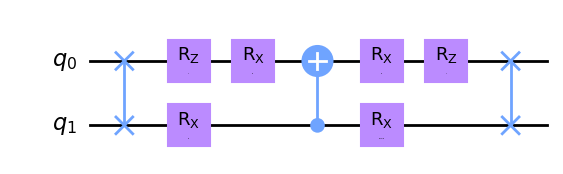

R^*


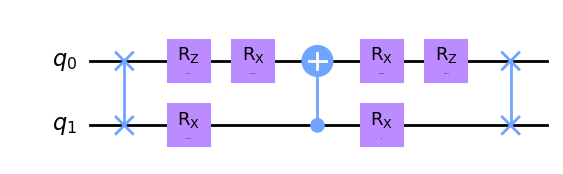

L


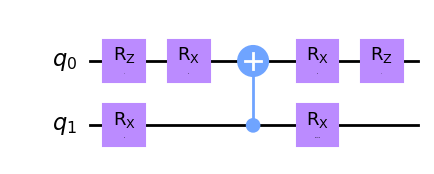

L^*


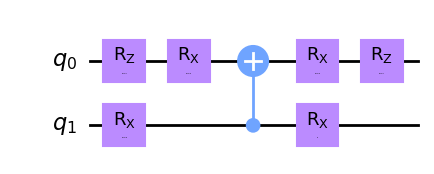

In [15]:
def create_mixed_env_circuit(params, name):
    qc = QuantumCircuit(2, name=name)
    if name=="R":
        qc.swap(0,1)
    qc.rz(params[0], 0)
    qc.rx(params[1], 0)
    
    qc.rx(params[2], 1)
    qc.cx(1,0)
    qc.rx(-params[2], 1)
    
    qc.rx(params[1], 0)
    qc.rz(params[0], 0)
    if name == "R":
        qc.swap(0,1)
    print(name)
    display(qc.draw())
    return qc.to_instruction()

def create_conjugated_mixed_env_circuit(params, name):
    """
    conjugating the whole matrix can be done by conjugating each gate.
    This means changing the sign for rx and rz while leaving it the same for ry.
    """
    qc = QuantumCircuit(2, name=name)
    if name[0]=="R":
        qc.swap(0,1)
    qc.rz(-params[0], 0)
    qc.rx(-params[1], 0)
    
    qc.rx(-params[2], 1)
    qc.cx(1,0)
    qc.rx(params[2], 1)
    
    qc.rx(-params[1], 0)
    qc.rz(-params[0], 0)
    if name[0] == "R":
        qc.swap(0,1)
    print(name)
    display(qc.draw())
    return qc.to_instruction()

# qiskit seems to internaly remember some things if we don't delete them first. otherwise it leads to unexpected behaviour.
# also there seems to be a weird connection between parameter names and Operator names. we get different results if Gate R is called "r".
try:
    del R, L, R_params, L_params
except:
    pass
R_params = Parameter("$r_1$"), Parameter("$r_2$"), Parameter("$r_3$")
R = create_mixed_env_circuit(R_params, "R")
R_conj = create_conjugated_mixed_env_circuit(R_params, "R^*")

L_params = Parameter("$l_1$"), Parameter("$l_2$"), Parameter("$l_3$")
L = create_mixed_env_circuit(L_params, "L")
L_conj = create_conjugated_mixed_env_circuit(L_params, "L^*")

In [16]:
def l(L, params, precission=20):
    unitaries = get_matrix_for_gate(L, params, precission)
    if type(unitaries) == list:
        return [unitary.to_matrix()[:2,:2].flatten() for unitary in unitaries]
    return unitaries.to_matrix()[:2,:2].flatten()
    
def r(R, params, precission=20):
    unitaries = get_matrix_for_gate(R, params, precission)
    if type(unitaries) == list:
        return [unitary.to_matrix()[::2,::2].flatten() for unitary in unitaries]
    return unitaries.to_matrix()[::2,::2].flatten()


In [17]:
from numpy.linalg import matrix_power

In [18]:
## check implementation of get_transfer_matrix and wrap_with_transfer_matrix

pow=3

L_param_n = get_params(L)
L_params_ = dict(zip(L_param_n, [1,2,3]))
l_ = l(L, L_params_)
tmpMPS = braMPS #create_temp_mps_copy(all_mps[20])
ketMPS =  mps# create_temp_mps_copy(all_mps[2])
W_ = W
# or some not hermitian W: (mps.U_mat was the nearest at hand. should be random enough)
#W_ = QuantumCircuit(2)
#W_.unitary(mps.U_mat, [0,1])

transfer_mat = get_transfer_matrix(ketMPS, tmpMPS, W_)
circ = wrap_with_transfer_matrix_n_times(L, ketMPS, tmpMPS, W_, pow).bind_parameters(join_params(L_params_, ketMPS.U_params, tmpMPS.U_params))
display(circ.draw())
l_transfer_mat_pow = get_matrix_for_gate(circ, precission=20).to_matrix()[:2,:2]

print("the following should be very small.")
l_transfer_mat_pow.flatten() - l_.T @ matrix_power(transfer_mat, pow) #should all be very small.

the following should be very small.


array([-5.44703171e-15+3.33066907e-16j,  5.35595873e-17+4.85722573e-17j,
       -3.29597460e-17-1.38777878e-17j, -5.17099384e-15+3.88578059e-16j])